- spec (Python 3.11.4)

In [39]:
# load libraries for data processing

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import chemometrics as cm
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
from chemometrics.mcr import McrAR
import chemometrics.mcr.constraint as constraint
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.utils.extmath import randomized_svd
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D

https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py

In [2]:
# Get CSV files list from a folder
path = 'f:/GAC_KSY/spectrum/1_amaranth/data/NIR_Gachon_amaranth'
mat_files = glob.glob(path + "/*.xlsx")
df_list = [pd.read_excel(file) for file in mat_files]
dfs = [df.set_index('Cm-1') for df in df_list]
df = pd.concat(dfs, axis=1)
df.sort_index(ascending = False, inplace = True)

# import data into dict
data = {}
for file in mat_files:
    data[file.split("/")[-1].replace(".xlsx","").replace('NIR_Gachon_amaranth\\Gachon_','')] = pd.read_excel(file, index_col=0)


info = {'Experiment': df.columns[1:]}
infodf = pd.DataFrame(info)

infodf['Group'] = infodf.Experiment.str.split("_").str[0]
labels = infodf['Group']
le = LabelEncoder().fit_transform(labels)
colors = [plt.cm.jet(float(i)/max(le)) for i in le]
infodf["Colors"] = colors 

mdf = pd.concat(df_list, ignore_index=False, axis = 1, join = "outer")
wl = pd.Series(mdf["Cm-1"].to_numpy().ravel(order="K"), name="ref")

분석할 컬럼(df1, csv저장)을 선택하여 sdf로 생성

In [3]:
import re
rm_word = ['Cm-1', '땅심이', 'NR','CG','S','Water', 'Etoh']

'''for grp in infodf["Group"]:
    if grp in rm_word:
        rm_list.append(grp)
'''
rm_list = []
for grp in infodf["Group"]:
    for word in rm_word:
        if re.search(word, grp):
            # print(grp)
            rm_list.append(grp)
print(rm_list)
mod_info = infodf[~infodf['Group'].isin(rm_list)]
print("Exp" , len(mod_info["Experiment"]))
infodf[~infodf['Group'].isin(rm_list)]["Group"].values

# for check
# mod_info[mod_info['Experiment'].isin([r'O[1-5]_230519'])]
# [len(re.findall('O[1-5]_230519', exp)) > 0 for exp in mod_info['Experiment']]
# for exp in mod_info['Experiment']:
#     if re.search('땅심이 O[1-5]_230519', exp) != None :
#          print(exp) 
# len(re.findall('O[1-5]_230519', '땅심이 O2_230519_212526.0000')) > 0

ll = list(set(mod_info["Experiment"]))
ll = ["_".join(line.split("_")[0:-1]) for line in ll]
ll = list(set(ll))

df1 = pd.DataFrame({"Analysis":ll})
df1.to_csv('Amaranth_colname.csv')

sdf = df[mod_info['Experiment']]
print(len(df.columns), len(sdf.columns))
import pickle
with open('../pickle/sdf.pickle', "wb") as fw:
    pickle.dump(sdf, fw)

print("Nan",pd.isna(sdf).sum())


['S441', 'S441', 'S441', 'S483', 'S483', 'S483', 'S496', 'S496', 'S496', 'S497', 'S497', 'S497', 'S498', 'S498', 'S498', 'Etoh', 'Etoh', 'Etoh', 'Water', 'Water', 'Water', '땅심이E2', '땅심이E2', '땅심이E2', '땅심이E3', '땅심이E3', '땅심이E3', '땅심이E4', '땅심이E4', '땅심이E4', '땅심이E5', '땅심이E5', '땅심이E5', 'NR Brain', 'NR Brain', 'NR Brain', 'NR Eyes', 'NR Eyes', 'NR Eyes', 'NR Gallbladder', 'NR Gallbladder', 'NR Gallbladder', 'NR Gill', 'NR Gill', 'NR Gill', 'NR Heart', 'NR Heart', 'NR Heart', 'NR Intestine', 'NR Intestine', 'NR Intestine', 'NR Kidney', 'NR Kidney', 'NR Kidney', 'NR Liver', 'NR Liver', 'NR Liver', 'NR Muscle', 'NR Muscle', 'NR Muscle', 'NR Ovary', 'NR Ovary', 'NR Ovary', 'NR Pyloric caeca', 'NR Pyloric caeca', 'NR Pyloric caeca', 'NR Skin', 'NR Skin', 'NR Skin', 'NR Skin', 'NR Skin', 'NR Skin', 'NR Stomach', 'NR Stomach', 'NR Stomach', 'NR Stomach', 'NR Stomach', 'NR Stomach', 'NR Testis', 'NR Testis', 'NR Testis', 'Water', 'Water', 'Water', 'NR Brain', 'NR Brain', 'NR Brain', 'NR Eyes', 'NR Eye

train test set split


In [19]:

tsdf = sdf.T

train_set = tsdf.sample(frac = 0.8, random_state = 200)
test_set = tsdf.drop(train_set.index)

print(len(train_set.index) , len(test_set), 
      len(tsdf),  len(train_set.index) + len(test_set))
print(train_set.index)


626 156 782 782
Index(['O281_20230809_132552.0000', 'O218_20230803_094412.0000',
       'O021_230605_194806.0001', 'E069_230610_155506.0000',
       'E025_230606_141345.0000', 'O076_230605_210909.0002',
       'O071_230605_210345.0001', 'O037_230605_201152.0002',
       'O040_230605_201551.0002', 'O062_230605_204713.0001',
       ...
       'O016_230605_194024.0000', 'E054_230610_154242.0002',
       'E042_230606_191121.0000', 'O080_230605_211340.0000',
       'O074_230605_210714.0001', 'O055_230605_203959.0000',
       'O089_230605_212522.0001', 'E097_230612_105205.0001',
       'E38_001_230503_150631.0001', 'E025_230606_141345.0001'],
      dtype='object', length=626)


In [ ]:
from sklearn.model_selection import train_test_split
# 필요한 라이브러리 불러오기
x0 = sdf.T.values
y0 = sdf.T.index


x_train, x_val, y_train, y_val = train_test_split(x0, y0, test_size=.2, random_state=2024)
y0

In [33]:
from sklearn.impute import KNNImputer

#임퓨터 선언(5개의 평균으로 계산하겠다)
imputer=KNNImputer(n_neighbors=5)
Xi = imputer.fit_transform(train_set.T)

Text(0, 0.5, 'Absorbance / mAU')

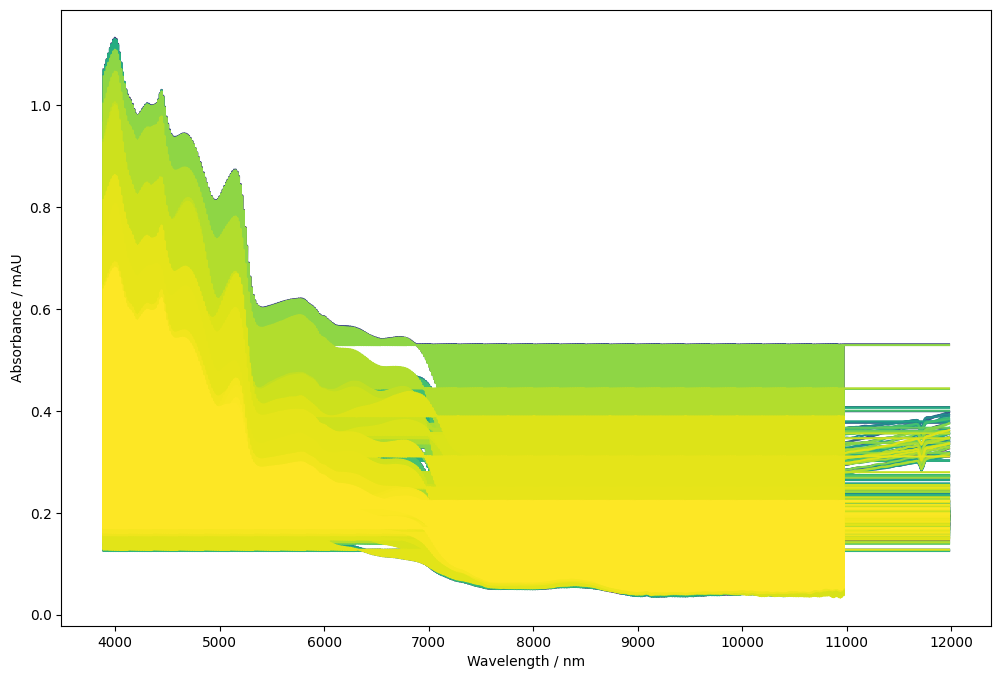

In [38]:

fig = plt.figure(figsize=(12, 8))
lines = cm.plot_colored_series(Xi, x=train_set.columns)
plt.xlabel('Wavelength / nm')
plt.ylabel('Absorbance / mAU')


Text(0, 0.5, 'Predictor signal')

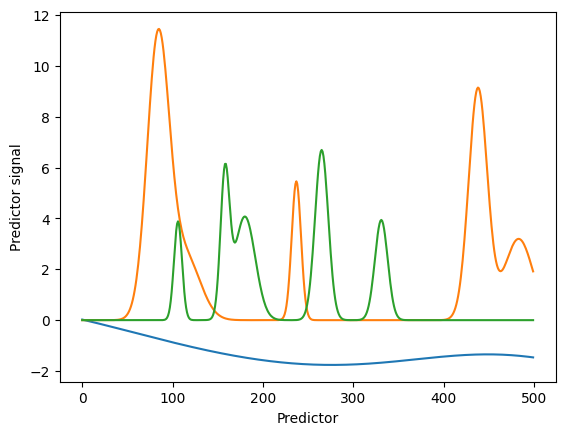

In [57]:
### tutorial pls emsc
n_wl = 500
n_band = 5
bandwidth = 3
n_samples = 625
noise = 0.2
target_component_height = 0.1

np.random.seed(1)
bg1 = cm.generate_background(n_wl)
bg2 = cm.generate_spectra(n_wl, n_band, bandwidth)
bg3 = cm.generate_spectra(n_wl, n_band, bandwidth)

plt.plot(bg1)
plt.plot(bg2)
plt.plot(bg3)

plt.xlabel('Predictor')
plt.ylabel('Predictor signal')

Text(0, 0.5, 'Predictor signal')

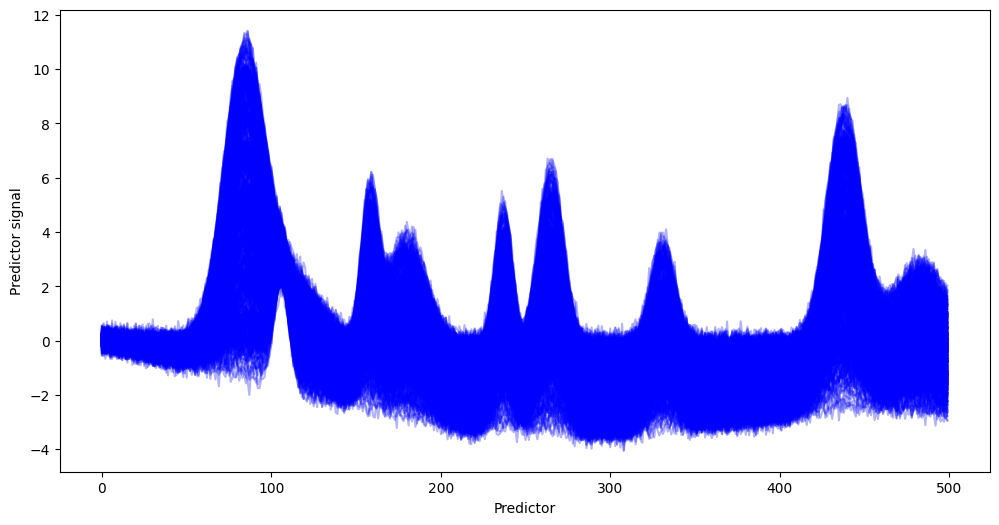

In [58]:
### tutorial pls emsc
plt.figure(figsize=[12, 6])
sample = np.arange(n_samples)[:,None]
background_wo_noise = bg1.T * np.random.uniform(size=[n_samples,1]) * 2 + sample/n_samples*bg2.T + (1-sample/n_samples) * bg3.T
background = background_wo_noise + np.random.normal(scale=noise, size=[n_samples, n_wl])

lines = plt.plot(background.T, 'blue', alpha=0.3)

plt.xlabel('Predictor')
plt.ylabel('Predictor signal')

Text(0, 0.5, 'Predictor signal')

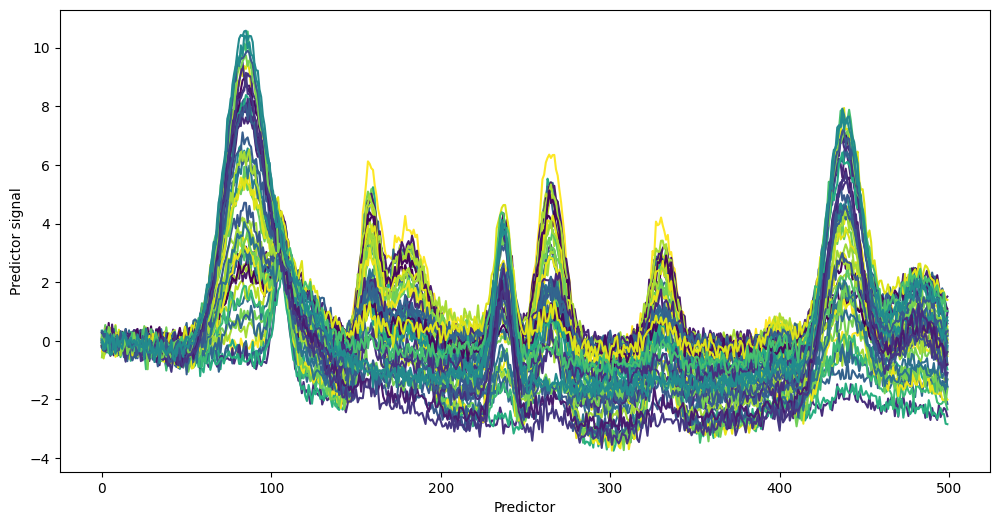

In [42]:
### tutorial pls emsc
y = np.random.uniform(high=target_component_height, size = [n_samples, 1])
pure_spec = cm.generate_spectra(n_wl, n_band, bandwidth)
spectra = background_wo_noise + y * pure_spec + np.random.normal(scale=noise, size=[n_samples, n_wl])

plt.figure(figsize=[12, 6])
lines = cm.plot_colored_series(spectra.T, reference=y[:,0])

plt.xlabel('Predictor')
plt.ylabel('Predictor signal')

(-0.5, 1.0)

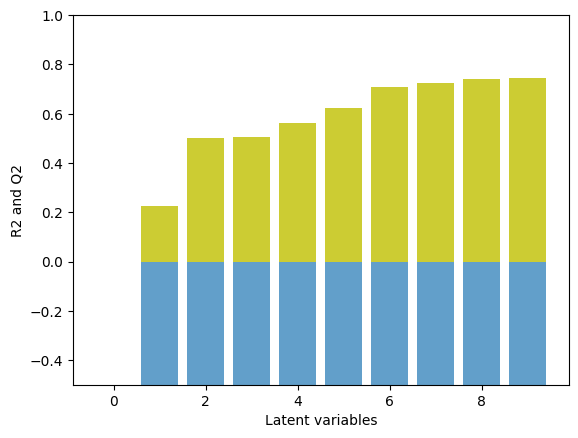

In [62]:
### tutorial pls emsc

def eval_pls(spectra, y):
    max_lv = 10

    scores_cv = np.zeros(max_lv)
    scores = np.zeros(max_lv)

    for i in range(1, max_lv):
        pls = cm.PLSRegression(n_components=i)
        scores_cv[i] = np.mean(cross_val_score(pls, spectra, y))
        scores[i] = pls.fit(spectra, y).score(spectra, y)

    plt.bar(np.arange(max_lv), scores, color=[0.8, 0.8, 0.2], alpha=1)
    plt.bar(np.arange(max_lv), scores_cv, alpha=0.7)

    plt.xlabel('Latent variables')
    plt.ylabel('R2 and Q2')

spectra = Xi
y = train_set.columns
eval_pls(spectra, y)
plt.ylim([-0.5, 1])



<Figure size 1200x100 with 0 Axes>

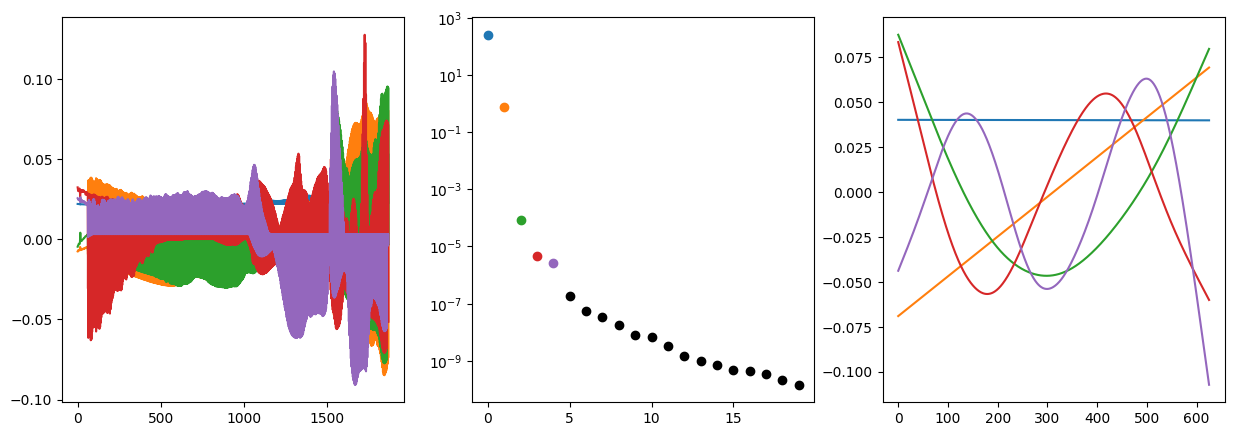

In [79]:

cm.plot_svd(cm.Whittaker().fit_transform(spectra), n_comp=5)

In [83]:
cm.plot_pca(cm.Whittaker.fit_transform(spectra), n_comp=5)

AttributeError: module 'chemometrics' has no attribute 'plot_pca'

R2: 0.6238056969936971




Text(0, 0.5, 'VIP')

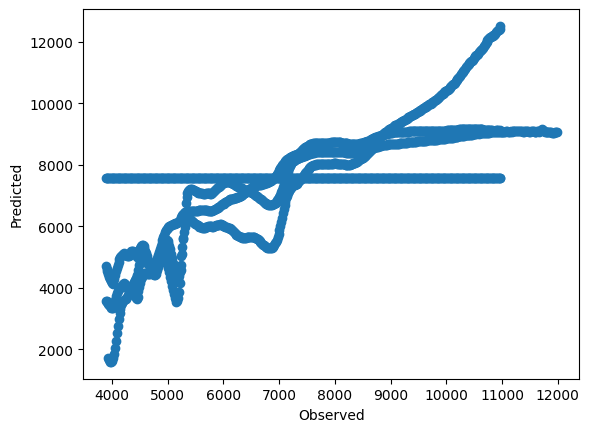

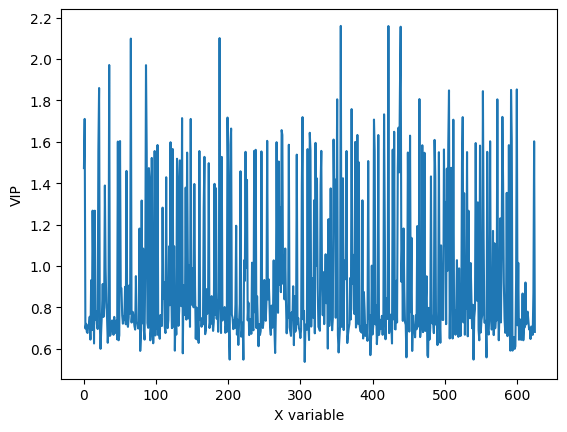

In [73]:
pls = cm.PLSRegression(n_components=5).fit(spectra, y)

print(f'R2: {pls.score(spectra, y)}\n\n')

plt.scatter(y, pls.predict(spectra)[:,0])
plt.xlabel('Observed')
plt.ylabel('Predicted')

plt.figure()
plt.plot(pls.vip_)
plt.xlabel('X variable')
plt.ylabel('VIP')

Text(0, 0.5, 'Predictor signal')

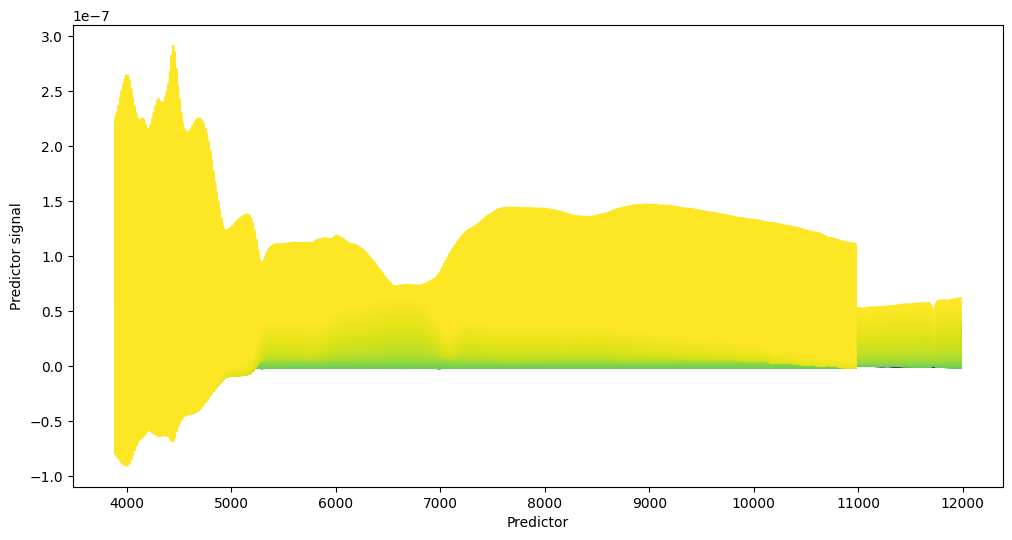

In [70]:
# extract background
# bg_pipeline = make_pipeline(cm.Whittaker(), TruncatedSVD(n_components=3))
# bg_pipeline = bg_pipeline.fit(background)
# right_singular_vectors = bg_pipeline[-1].components_.T

# construct pipeline and treat spectra
pipeline = make_pipeline(cm.Whittaker(), cm.Emsc())
spectra_pretreated = pipeline.fit_transform(spectra)

spectra_pretreated
plt.figure(figsize=[12, 6])
lines = cm.plot_colored_series(spectra_pretreated, x=train_set.columns)
plt.xlabel('Predictor')
plt.ylabel('Predictor signal')

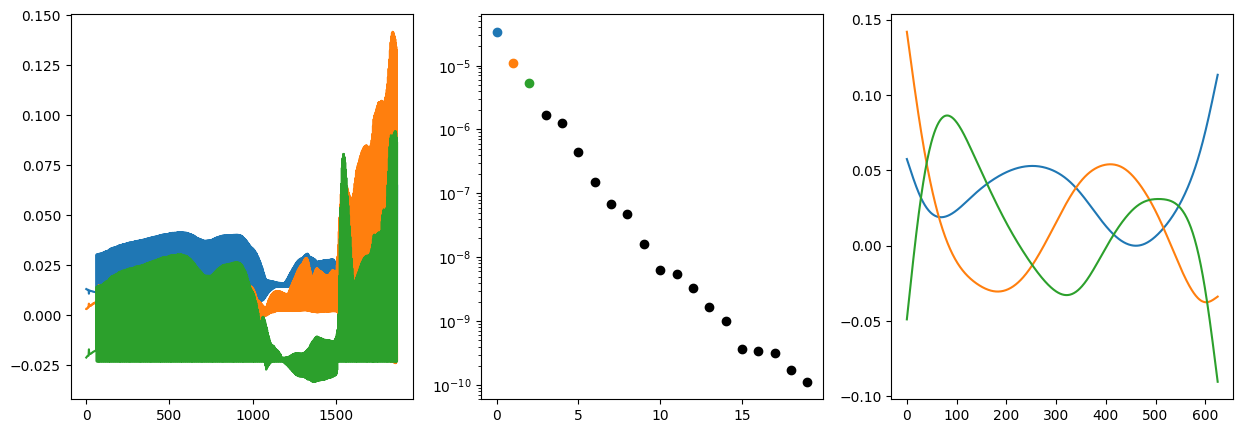

In [81]:

cm.plot_svd(cm.Whittaker().fit_transform(spectra_pretreated), n_comp=3)

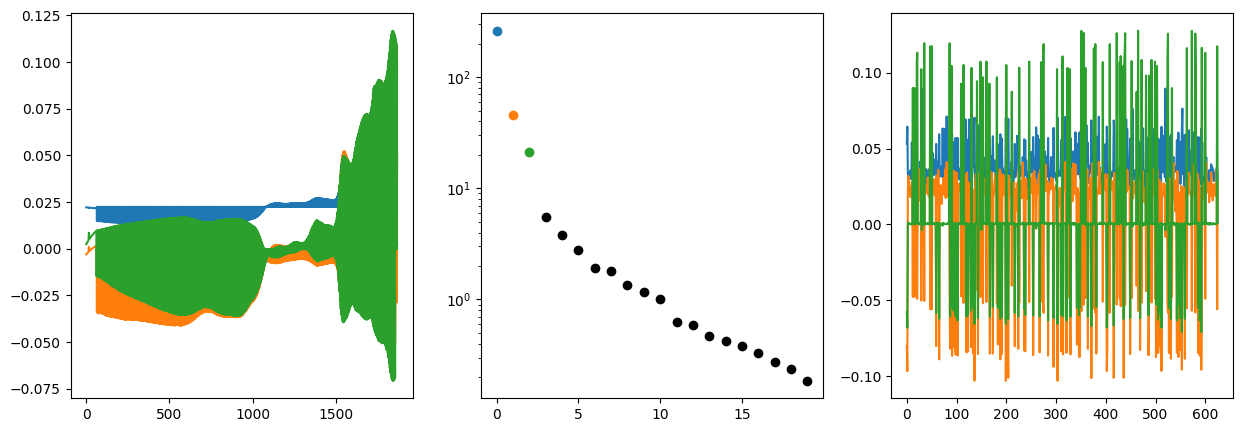

In [82]:
cm.plot_svd(spectra, n_comp=3)

Text(0, 0.5, 'VIP')

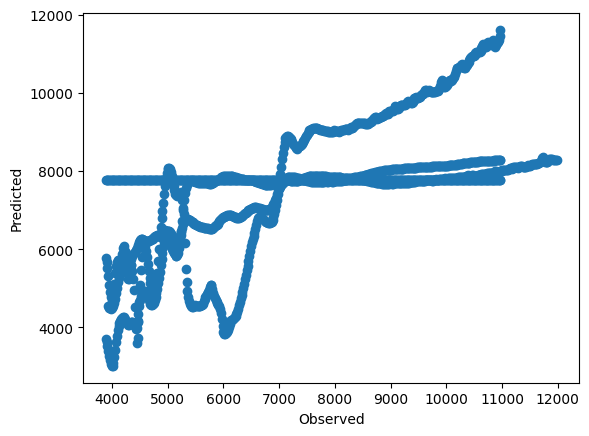

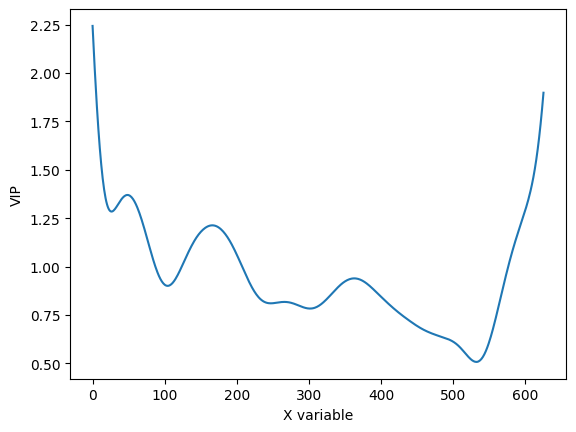

In [74]:
pls = cm.PLSRegression(n_components=5).fit(spectra_pretreated, y)

plt.scatter(y, pls.predict(spectra_pretreated)[:,0])
plt.xlabel('Observed')
plt.ylabel('Predicted')

plt.figure()
plt.plot(pls.vip_)
plt.xlabel('X variable')
plt.ylabel('VIP')

Impute the missing data and score

In [23]:
rng = np.random.RandomState(0)

from sklearn.ensemble import RandomForestRegressor

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

N_SPLITS = 4
regressor = RandomForestRegressor(random_state=0)

Missing information

In [133]:
import numpy as np

from sklearn.datasets import fetch_california_housing, load_diabetes

rng = np.random.RandomState(42)

# X_diabetes, y_diabetes = load_diabetes(return_X_y=True)
# print(X_diabetes.shape, y_diabetes.shape) # (442, 10) (442,)
X = sdf.values
y = sdf.index


def get_scores_for_imputer(imputer, X_missing, y_missing):
    estimator = make_pipeline(imputer, regressor)
    impute_scores = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return impute_scores


x_labels = []

mses = np.zeros(5)
stds = np.zeros(5)


Estimate the score
ValueError(msg_err)\nValueError: Input X contains NaN.\nRandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values\n

In [49]:
def get_full_score(X_full, y_full):
    full_scores = cross_val_score(
        regressor, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return full_scores.mean(), full_scores.std()


mses[0], stds[0] = get_full_score(X, y)
x_labels.append("Full data")


ValueError: 
All the 4 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\somrs\anaconda3\envs\spec\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\somrs\anaconda3\envs\spec\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\somrs\anaconda3\envs\spec\Lib\site-packages\sklearn\ensemble\_forest.py", line 348, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\somrs\anaconda3\envs\spec\Lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\somrs\anaconda3\envs\spec\Lib\site-packages\sklearn\utils\validation.py", line 1147, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\somrs\anaconda3\envs\spec\Lib\site-packages\sklearn\utils\validation.py", line 959, in check_array
    _assert_all_finite(
  File "c:\Users\somrs\anaconda3\envs\spec\Lib\site-packages\sklearn\utils\validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "c:\Users\somrs\anaconda3\envs\spec\Lib\site-packages\sklearn\utils\validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


Replace missing values by 0

In [50]:
def get_impute_zero_score(X_missing, y_missing):
    imputer = SimpleImputer(
        missing_values=np.nan, add_indicator=True, strategy="constant", fill_value=0
    )
    zero_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return zero_impute_scores.mean(), zero_impute_scores.std()


mses[1], stds[1] = get_impute_zero_score(
    X, y
)

x_labels.append("Zero imputation")

kNN-imputation of the missing values

In [51]:
def get_impute_knn_score(X_missing, y_missing):
    imputer = KNNImputer(missing_values=np.nan, add_indicator=True)
    knn_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return knn_impute_scores.mean(), knn_impute_scores.std()


mses[2], stds[2] = get_impute_knn_score(
    X, y
)

x_labels.append("KNN Imputation")

Impute missing values with mean

In [52]:
def get_impute_mean(X_missing, y_missing):
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=True)
    mean_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return mean_impute_scores.mean(), mean_impute_scores.std()


mses[3], stds[3] = get_impute_mean(
    X, y
)
x_labels.append("Mean Imputation")

Iterative imputation of the missing values

In [54]:
def get_impute_iterative(X_missing, y_missing):
    imputer = IterativeImputer(
        missing_values=np.nan,
        add_indicator=True,
        random_state=0,
        n_nearest_features=3,
        max_iter=1,
        sample_posterior=True,
    )
    iterative_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return iterative_impute_scores.mean(), iterative_impute_scores.std()


mses[4], stds[4] = get_impute_iterative(
    X, y
)

x_labels.append("Iterative Imputation")

mses = mses * -1


In [64]:
x_labels = ["Full data", "Zero imputation", "KNN Imputation"
            , "Mean Imputation", "Iterative Imputation" ]



array([     -0.        , 3978857.02278071, 4081240.9494557 ,
       4081240.9494557 , 4030967.8886337 ])

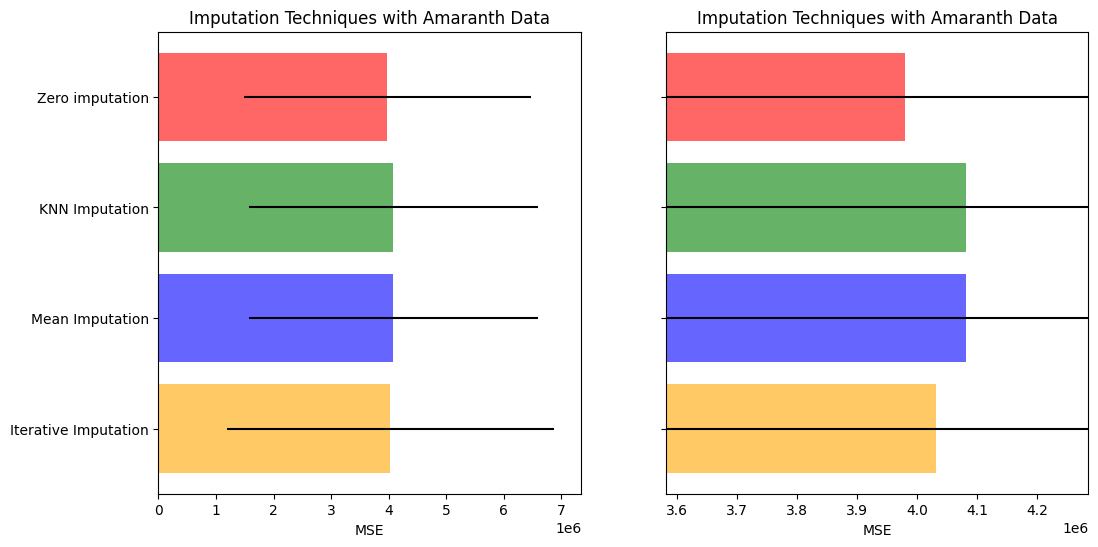

In [ ]:
import matplotlib.pyplot as plt

n_bars = len(mses[1:])
xval = np.arange(n_bars)

colors = ["r", "g", "b", "orange", "black"]

# plot diabetes results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
for j in xval:
    ax1.barh(
        j,
        mses[1:][j],
        xerr=stds[1:][j],
        color=colors[j],
        alpha=0.6,
        align="center",
    )

ax1.set_title("Imputation Techniques with Amaranth Data")
ax1.set_xlim(left=np.min(mses[1:]) * 0, right=np.max(mses[1:]) * 1.8)
ax1.set_yticks(xval)
ax1.set_xlabel("MSE")
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels[1:])

# plot california dataset results
ax2 = plt.subplot(122)
for j in xval:
    ax2.barh(
        j,
        mses[1:][j],
        xerr=stds[1:][j],
        color=colors[j],
        alpha=0.6,
        align="center",
    )

ax2.set_title("Imputation Techniques with Amaranth Data")
ax2.set_xlim(left=np.min(mses[1:]) * 0.9, right=np.max(mses[1:]) * 1.05)
ax2.set_yticks(xval)
ax2.set_xlabel("MSE")
ax2.invert_yaxis()
ax2.set_yticklabels([""] * n_bars)
mses


Text(0, 0.5, 'Absorbance / mAU')

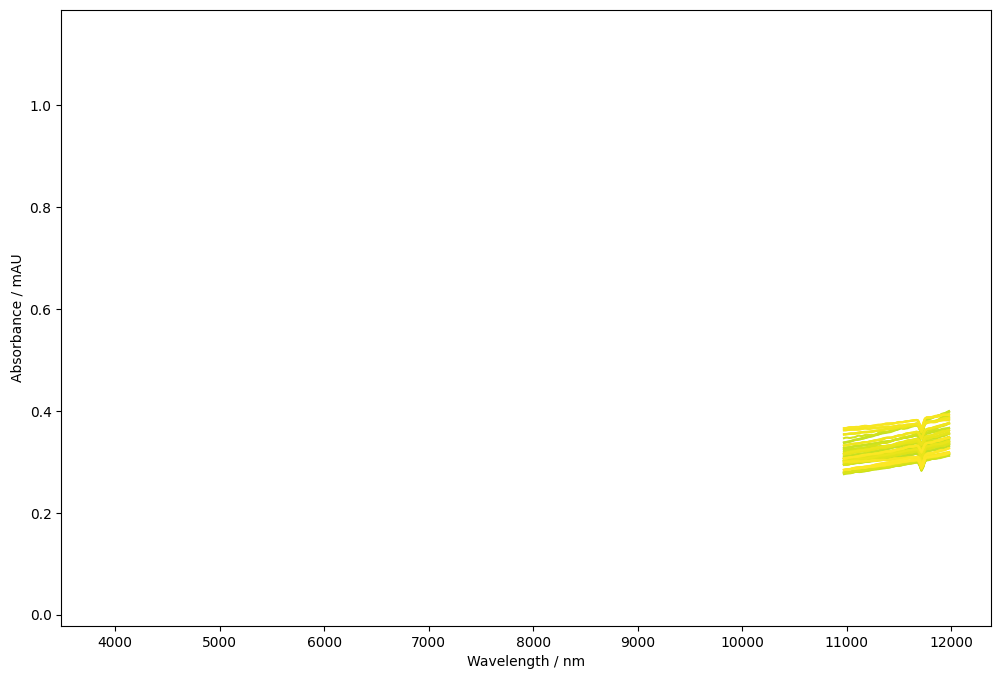

In [50]:
wavelengths = sdf.index
fig = plt.figure(figsize=(12, 8))
lines = cm.plot_colored_series(sdf.values, x=wavelengths)
plt.xlabel('Wavelength / nm')
plt.ylabel('Absorbance / mAU')


In [31]:

#사용하면 array값으로 나오기때문에 dataframe으로 바꿔주고 컬럼을가져옴
filled_train=pd.DataFrame(filled_train, columns=y_train)

ValueError: Shape of passed values is (500, 1409), indices imply (500, 500)

In [13]:
filled_train.shape

(1196, 782)

In [138]:
df.info
df.isna().sum()

tmp = df
tmp.interpolate(inplace = True)
tmp.head(7)

,E46_res32_001_230428_104059.0000,E46_res32_001_230428_104059.0001,E46_res32_001_230428_104059.0002,E47_res32_001_230428_105353.0000,E47_res32_001_230428_105353.0001,E47_res32_001_230428_105353.0002,O46_res32_001_230428_103400.0000,O46_res32_001_230428_103400.0001,O46_res32_001_230428_103400.0002,O47_res32_001_230428_104409.0000,...,O249_20230803_095423.0002,O257_20230803_095922.0000,O257_20230803_095922.0001,O257_20230803_095922.0002,O281_20230809_132552.0000,O281_20230809_132552.0001,O281_20230809_132552.0002,O289_20230809_133825.0000,O289_20230809_133825.0001,O289_20230809_133825.0002
Cm-1,,,,,,,,,,,,,,,,,,,,,
11978.763096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.392544,0.348298,0.347445,0.347225,0.326282,0.326888,0.327006,0.318881,0.317077,0.317932
11962.286118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.391840,0.347667,0.346360,0.346404,0.325454,0.325825,0.325553,0.317890,0.315331,0.316474
11945.809139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.392046,0.346464,0.345500,0.346487,0.323655,0.324425,0.324081,0.316263,0.314166,0.315346
11929.332161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.392294,0.344567,0.345172,0.346491,0.322276,0.323257,0.323386,0.315273,0.313594,0.315278
11912.855183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.391499,0.342839,0.344407,0.345225,0.321882,0.322344,0.323460,0.315153,0.313081,0.315105
11896.378205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.390345,0.341770,0.343491,0.343083,0.321233,0.321454,0.323288,0.314793,0.312290,0.314252
11879.901227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.389543,0.340994,0.342990,0.341742,0.319979,0.320625,0.322107,0.313853,0.311296,0.313166


In [129]:
#EMSC rescaling
from ChemUtils import EmscScaler

emsc = EmscScaler()

emsc.fit(X)

X_train_emsc = emsc.transform(X)
_ = plt.plot(dataset['axisscale'],X_train_emsc.T)

ValueError: array must not contain infs or NaNs

In [73]:
# https://dev.to/balapriya/having-trouble-with-missing-data-here-s-how-you-can-handle-them-better-42d6
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
# Mean Imputation
imputer = SimpleImputer()
imputer.fit_transform(X)

# impute the mean and add an indicator matrix (new in scikit-learn 0.21)
imputer = SimpleImputer(add_indicator=True)
imputer.fit_transform(X)

labels = mod_info['Group']
le = LabelEncoder().fit_transform(labels)

clf = HistGradientBoostingClassifier().fit(X.T, le)
clf.score(X.T, le)

1.0